In [1]:
import os
import yaml
import requests
import zipfile
import glob
import shutil
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr, osr
from pathlib import Path
from rasterio.windows import from_bounds
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona
import geopandas as gpd
from bmi_topography import Topography
from landlab.io import esri_ascii, write_esri_ascii
import matplotlib as mpl
import matplotlib.pyplot as plt
from landlab import imshowhs_grid, imshow_grid, imshow_grid_at_node
from matplotlib.colors import ListedColormap
import time

Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_pre.tif /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_post.tif /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_pre.asc /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_post.asc


In [ ]:
from pathlib import Path
import shutil
import rasterio

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")

pre_src  = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/input/pre_step_010_class_2.tif")
post_src = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/input/pre_step_010_class_2.tif")

# copy to output with standard names
pre_tif  = out_dir / "dem_pre.tif"
post_tif = out_dir / "dem_post.tif"

if not pre_src.exists():
    raise FileNotFoundError(pre_src)
if not post_src.exists():
    raise FileNotFoundError(post_src)

shutil.copy(pre_src, pre_tif)
shutil.copy(post_src, post_tif)

def tif_to_asc(tif_path, asc_path):
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        transform = src.transform
        nodata = src.nodata if src.nodata is not None else -9999

        nrows, ncols = data.shape
        xll = transform.c
        yll = transform.f + transform.e * nrows
        cellsize = transform.a

        with open(asc_path, "w") as f:
            f.write(f"ncols         {ncols}\n")
            f.write(f"nrows         {nrows}\n")
            f.write(f"xllcorner     {xll}\n")
            f.write(f"yllcorner     {yll}\n")
            f.write(f"cellsize      {cellsize}\n")
            f.write(f"NODATA_value  {nodata}\n")
            for row in data:
                row = [str(nodata) if (v is None or (v != v)) else str(v) for v in row]
                f.write(" ".join(row) + "\n")

tif_to_asc(pre_tif,  out_dir / "dem_pre.asc")
tif_to_asc(post_tif, out_dir / "dem_post.asc")

print("Saved:", pre_tif, post_tif, out_dir / "dem_pre.asc", out_dir / "dem_post.asc")

import rasterio
import numpy as np
from pathlib import Path

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")

pre_tif  = out_dir / "dem_pre.tif"
post_tif = out_dir / "dem_post.tif"
diff_tif = out_dir / "dem_diff.tif"

with rasterio.open(pre_tif) as pre, rasterio.open(post_tif) as post:
    pre_arr = pre.read(1)
    post_arr = post.read(1)

    diff = post_arr - pre_arr

    meta = post.meta.copy()
    with rasterio.open(diff_tif, "w", **meta) as dst:
        dst.write(diff, 1)

print("Saved:", diff_tif)


from pathlib import Path
import rasterio
import numpy as np

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")
diff_tif = out_dir / "dem_diff.tif"
diff_asc = out_dir / "dem_diff.asc"

with rasterio.open(diff_tif) as src:
    data = src.read(1)
    transform = src.transform
    nodata = src.nodata if src.nodata is not None else -9999

    nrows, ncols = data.shape
    xll = transform.c
    yll = transform.f + transform.e * nrows
    cellsize = transform.a

    with open(diff_asc, "w") as f:
        f.write(f"ncols         {ncols}\n")
        f.write(f"nrows         {nrows}\n")
        f.write(f"xllcorner     {xll}\n")
        f.write(f"yllcorner     {yll}\n")
        f.write(f"cellsize      {cellsize}\n")
        f.write(f"NODATA_value  {nodata}\n")
        for row in data:
            row = [str(nodata) if (v is None or (v != v)) else str(v) for v in row]
            f.write(" ".join(row) + "\n")

print("Saved:", diff_asc)

Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif
Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.asc


In [3]:
%cd /home/abdullah/fire-debrisflow-ml

pre = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/pre_step_010_class_2.tif"
post = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/post_step_010_class_2.tif"
out_dir = "/mnt/c/Users/amehedi/Downloads/ml_debris/output"
config = "config/base.yaml"

!python src/dem_difference.py --pre "{pre}" --post "{post}" --out-dir "{out_dir}" --config "{config}"

/home/abdullah/fire-debrisflow-ml
Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif
Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.asc
Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_pre.asc /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_post.asc


In [2]:
import os
import rasterio

output_dir = "/mnt/c/Users/amehedi/Downloads/ml_debris/output"
asc_path = os.path.join(output_dir, "soil__thickness.asc")
tif_path = os.path.join(output_dir, "soil__thickness.tif")

with rasterio.open(asc_path) as src:
    data = src.read(1)
    meta = src.meta.copy()

meta.update(driver="GTiff", count=1)

with rasterio.open(tif_path, "w", **meta) as dst:
    dst.write(data, 1)

print("Saved:", tif_path)

Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/soil__thickness.tif


In [7]:
import os
import sys

repo_root = "/home/abdullah/fire-debrisflow-ml"
src_path = os.path.join(repo_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from reproject_and_resample import reproject_raster_to_match_crs

input_tif = "/mnt/c/Users/amehedi/Downloads/ml_debris/output/soil__thickness.tif"
dem_pre_tif = "/mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_pre.tif"

import rasterio
with rasterio.open(dem_pre_tif) as src:
    target_epsg = src.crs.to_epsg()
    if target_epsg is None:
        raise ValueError("dem_pre.tif CRS has no EPSG code.")

reproj_path = reproject_raster_to_match_crs(
    input_tif,
    target_crs_epsg=target_epsg,
    resampling_method="bilinear",
)

print("Saved:", reproj_path)

Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/soil__thickness_reproj_26911.tif


In [6]:
import os
import numpy as np
import rasterio

# path to your highlighted tif
input_tif = "/mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_post.tif"

with rasterio.open(input_tif) as src:
    z = src.read(1).astype("float32")
    z[z == src.nodata] = np.nan

    # pixel size
    dx, dy = src.res
    # gradient
    dz_dy, dz_dx = np.gradient(z, dy, dx)
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    slope_deg = np.degrees(slope_rad)

    # write output
    out_meta = src.meta.copy()
    out_meta.update(dtype="float32", nodata=-9999.0, count=1)

    out_dir = os.path.dirname(input_tif)
    out_tif = os.path.join(out_dir, "slope_post.tif")

    slope_out = np.where(np.isnan(slope_deg), out_meta["nodata"], slope_deg).astype("float32")

    with rasterio.open(out_tif, "w", **out_meta) as dst:
        dst.write(slope_out, 1)

print("Saved:", out_tif)

Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/slope_post.tif


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = df.drop(columns=["dem_diff"])
y = df["dem_diff"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = mse ** 0.5
print("RMSE:", rmse)

r2 = r2_score(y_test, pred)
print("R2:", r2)

NameError: name 'df' is not defined

In [ ]:
s = pd.Series(grid.at_node["dem_diff"])
s = pd.to_numeric(s, errors="coerce")   # force numeric
s = s.replace(-9999, np.nan).dropna()

s.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    550188.000000
mean          0.056154
std          14.787808
min         -91.476560
5%           -0.233154
25%          -0.040527
50%          -0.008301
75%           0.012207
95%           0.068115
max        1865.104600
dtype: float64

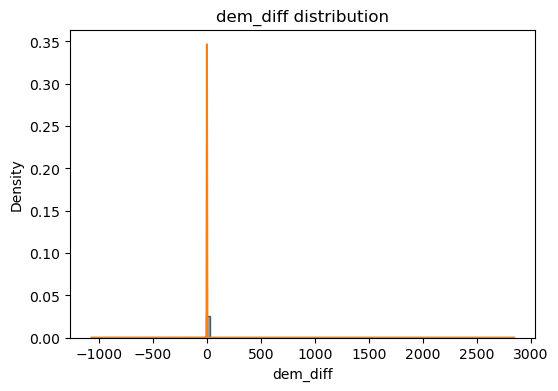

In [ ]:
# histogram + density
vals = pd.Series(grid.at_node["dem_diff"]).replace(-9999, pd.NA).dropna()

plt.figure(figsize=(6,4))
plt.hist(vals, bins=50, density=True, alpha=0.6, edgecolor="k")
vals.plot(kind="kde")
plt.title("dem_diff distribution")
plt.xlabel("dem_diff")
plt.ylabel("Density")
plt.show()

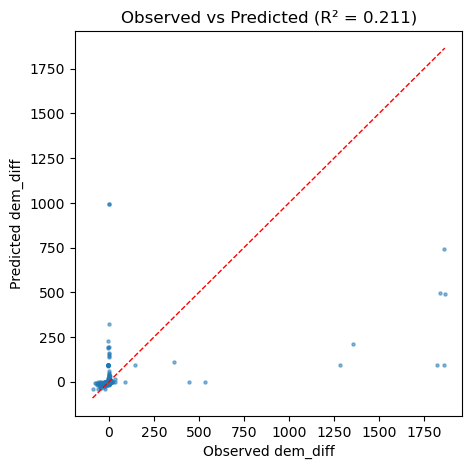

In [24]:
r2 = r2_score(y_test, pred)

plt.figure(figsize=(5,5))
plt.scatter(y_test, pred, s=5, alpha=0.5)
plt.xlabel("Observed dem_diff")
plt.ylabel("Predicted dem_diff")
plt.title(f"Observed vs Predicted (R² = {r2:.3f})")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=1)
plt.show()

In [28]:
# predict for all nodes
X_all = pd.DataFrame({v: grid.at_node[v] for v in vars_of_interest if v != "dem_diff"})
X_all = X_all.replace(-9999, np.nan).fillna(0)  # simple fill

pred_all = rf.predict(X_all)
grid.add_field("dem_diff_pred", pred_all, at="node", clobber=True)


array([-0.10852634, -0.10852634, -0.10852634, ..., -0.10852634,
       -0.10852634, -0.10852634], shape=(1006824,))

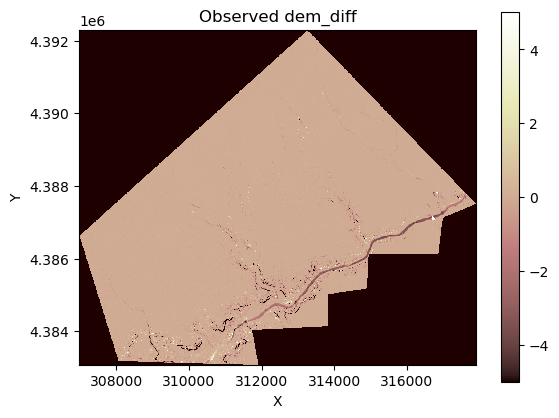

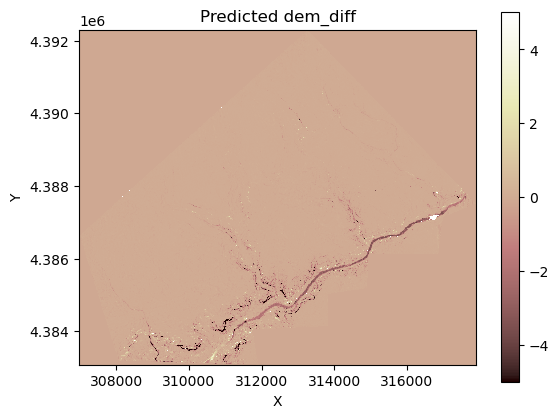

In [39]:
vmin = -5
vmax = 5

plt.figure()
imshow_grid(grid, "dem_diff", plot_name="Observed dem_diff", limits=(vmin, vmax))
plt.show()

plt.figure()
imshow_grid(grid, "dem_diff_pred", plot_name="Predicted dem_diff", limits=(vmin, vmax))
plt.show()

In [30]:
train_pred = rf.predict(X_train)
test_pred  = rf.predict(X_test)

train_r2 = r2_score(y_train, train_pred)
test_r2  = r2_score(y_test, test_pred)

print("Train R2:", train_r2)
print("Test R2:", test_r2)


Train R2: 0.878628651711292
Test R2: 0.21107814677338577


In [43]:
from pathlib import Path
import numpy as np
import pyproj

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")
out_asc = out_dir / "dem_diff_pred.asc"
out_prj = out_dir / "dem_diff_pred.prj"

# REQUIRED: set these from your grid/known values
nrows, ncols = grid.shape  # works if grid has shape
cellsize = 10  # meters (from your layer info)

# REQUIRED: set lower-left corner (xll, yll) in EPSG:32613
# Put the correct values here (from your existing layer info)
xll = 306982.9351981145
yll = 4392303.264309346

data = np.asarray(grid.at_node["dem_diff_pred"]).reshape(nrows, ncols)

with open(out_asc, "w") as f:
    f.write(f"ncols         {ncols}\n")
    f.write(f"nrows         {nrows}\n")
    f.write(f"xllcorner     {xll}\n")
    f.write(f"yllcorner     {yll}\n")
    f.write(f"cellsize      {cellsize}\n")
    f.write(f"NODATA_value  -9999\n")
    for row in data:
        f.write(" ".join(map(str, row)) + "\n")

# write .prj
crs = pyproj.CRS.from_epsg(32613)
out_prj.write_text(crs.to_wkt())

print("Saved:", out_asc, out_prj)


Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff_pred.asc /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff_pred.prj


In [ ]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import requests

# AOI
aoi_path = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/atl2017_perim_feat.shp"
aoi = gpd.read_file(aoi_path).to_crs(4326)

# USGS WESM GeoPackage (spatial metadata)
wesm_url = "https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/metadata/WESM.gpkg"
wesm_path = Path("/tmp/WESM.gpkg")

if not wesm_path.exists():
    r = requests.get(wesm_url, stream=True, timeout=60)
    r.raise_for_status()
    with open(wesm_path, "wb") as f:
        for chunk in r.iter_content(1024 * 1024):
            if chunk:
                f.write(chunk)

wesm = gpd.read_file(wesm_path)

# ensure CRS
if wesm.crs is None:
    wesm = wesm.set_crs(4326)
wesm = wesm.to_crs(aoi.crs)

# spatial filter
aoi_union = aoi.unary_union
wesm_aoi = wesm[wesm.intersects(aoi_union)].copy()

# parse acquisition dates
for c in ["collect_start", "collect_end"]:
    if c in wesm_aoi.columns:
        wesm_aoi[c] = pd.to_datetime(wesm_aoi[c], errors="coerce")

# show acquisition dates by work unit
cols = [c for c in ["workunit", "workunit_id", "collect_start", "collect_end"] if c in wesm_aoi.columns]
wesm_aoi[cols].sort_values(["collect_start", "collect_end"])

In [ ]:
import geopandas as gpd
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from pathlib import Path
from urllib.parse import urlparse, parse_qs

# --- WESM ---
wesm_url = "https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/metadata/WESM.gpkg"
wesm_path = Path("/tmp/WESM.gpkg")
if not wesm_path.exists():
    r = requests.get(wesm_url, stream=True, timeout=60)
    r.raise_for_status()
    with open(wesm_path, "wb") as f:
        for chunk in r.iter_content(1024 * 1024):
            if chunk:
                f.write(chunk)

wesm = gpd.read_file(wesm_path)

# pick the two workunit IDs you want
targets = {
    177292: "dem_pre",   # CA_NoCAL_Wildfires_B5b_2018
    300636: "dem_post",  # CA_NorthCoastRanges_2_B23
}

sel = wesm[wesm["workunit_id"].isin(targets.keys())].copy()
sel[["workunit","workunit_id","collect_start","collect_end","sourcedem_link"]]

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.warp import transform_bounds
from shapely.geometry import box
from pathlib import Path
import requests
import xml.etree.ElementTree as ET
from urllib.parse import urlparse, parse_qs

# --- AOI ---
aoi = gpd.read_file("/mnt/c/Users/amehedi/Downloads/ml_debris/input/atl2017_perim_feat.shp").to_crs(4326)
aoi_bounds = aoi.total_bounds  # (minx, miny, maxx, maxy)

def intersects_aoi(url, aoi_bounds_wgs84):
    # read header only (fast), no full download
    with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
        with rasterio.open(f"/vsicurl/{url}") as src:
            aoi_in_tile = transform_bounds("EPSG:4326", src.crs, *aoi_bounds_wgs84, densify_pts=21)
            return box(*aoi_in_tile).intersects(box(*src.bounds))

def s3_list_tifs_from_sourcedem_link(sourcedem_link):
    if not sourcedem_link:
        return []
    qs = parse_qs(urlparse(sourcedem_link).query)
    prefix = qs.get("prefix", [None])[0]
    if not prefix:
        return []
    prefix = prefix.strip("/") + "/"

    base = "https://prd-tnm.s3.amazonaws.com"
    urls = []
    token = None

    while True:
        params = {"list-type": "2", "prefix": prefix}
        if token:
            params["continuation-token"] = token

        r = requests.get(base, params=params, timeout=60)
        r.raise_for_status()
        root = ET.fromstring(r.text)
        ns = {"s3": "http://s3.amazonaws.com/doc/2006-03-01/"}

        for k in root.findall("s3:Contents/s3:Key", ns):
            key = k.text
            if key.lower().endswith(".tif"):
                urls.append(f"{base}/{key}")

        token_el = root.find("s3:NextContinuationToken", ns)
        if token_el is None or not token_el.text:
            break
        token = token_el.text

    return urls

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")
dem_src_dir = out_dir / "dem_source_tiles"
dem_src_dir.mkdir(exist_ok=True)

workunit_tifs = {}
for _, row in sel.iterrows():
    name = targets[row["workunit_id"]]

    # list all tiles in the work unit
    urls = s3_list_tifs_from_sourcedem_link(row.get("sourcedem_link"))
    if not urls:
        print("No source DEM link for", row["workunit_id"])
        continue

    # filter to AOI
    urls = [u for u in urls if intersects_aoi(u, aoi_bounds)]
    print(name, "tiles:", len(urls))

    paths = []
    for url in urls:
        local = dem_src_dir / Path(url).name
        if not local.exists():
            r = requests.get(url, stream=True, timeout=60)
            r.raise_for_status()
            with open(local, "wb") as f:
                for chunk in r.iter_content(1024 * 1024):
                    if chunk:
                        f.write(chunk)
        paths.append(local)

    workunit_tifs[name] = paths 

In [ ]:
import rasterio
from rasterio.merge import merge
from landlab.io import esri_ascii

# use your existing helper functions:
# reproject_raster_to_match_crs, resample_raster, clip_raster_to_shape, convert_to_ascii

clip_shapefile = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/grz2020_perim_feat.shp"
target_resolution = 10

# template_meta from your topographic__elevation.asc
with rasterio.open(out_dir / "topographic__elevation.asc") as src:
    template_meta = src.meta.copy()

def mosaic_tifs(tif_list, out_path):
    srcs = [rasterio.open(p) for p in tif_list]
    mosaic, transform = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": transform
    })
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(mosaic)
    for s in srcs:
        s.close()
    return out_path

def make_dem_field(src_tif, field_name):
    reproj = reproject_raster_to_match_crs(
        str(src_tif), target_crs_epsg=template_meta["crs"].to_epsg(),
        resampling_method="cubic", template_meta=template_meta
    )
    resamp = resample_raster(
        reproj, template_meta=template_meta,
        resampling_method="cubic", target_resolution=target_resolution
    )
    clipped = clip_raster_to_shape(resamp, clip_shapefile, template_meta=template_meta)
    asc = convert_to_ascii(clipped, out_dir, template_meta=template_meta)

    with open(asc, "r") as f:
        tmp = esri_ascii.load(f, name=field_name)

    grid.add_field(field_name, tmp.at_node[field_name], at="node", clobber=True)
    return grid.at_node[field_name]

dem_pre_tif  = mosaic_tifs(workunit_tifs["dem_pre"],  out_dir / "dem_pre_mosaic.tif")
dem_post_tif = mosaic_tifs(workunit_tifs["dem_post"], out_dir / "dem_post_mosaic.tif")

dem_pre  = make_dem_field(dem_pre_tif,  "dem_pre")
dem_post = make_dem_field(dem_post_tif, "dem_post")

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import json

def filter_urls_parallel(urls, aoi_geom, max_workers=32):
    keep = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {ex.submit(intersects_aoi_geom, u, aoi_geom): u for u in urls}
        for i, fut in enumerate(as_completed(futs), 1):
            u = futs[fut]
            try:
                if fut.result():
                    keep.append(u)
            except Exception:
                pass
            if i % 200 == 0:
                print(f"checked {i}/{len(urls)}")
    return keep

for _, row in sel.iterrows():
    name = targets[row["workunit_id"]]
    urls = s3_list_tifs_from_sourcedem_link(row.get("sourcedem_link"))

    # cache filtered list
    cache_file = out_dir / f"{name}_filtered_urls.json"
    if cache_file.exists():
        urls = json.loads(cache_file.read_text())
    else:
        urls = filter_urls_parallel(urls, aoi_geom, max_workers=32)
        cache_file.write_text(json.dumps(urls))

    print(name, "tiles after filter:", len(urls))

In [ ]:
import json
import geopandas as gpd
import rasterio
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
import subprocess
from pathlib import Path
import shutil

# paths
aoi_path = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/atl2017_perim_feat.shp"
out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")

# AOI + CRS (fix: set template_crs from AOI)
aoi = gpd.read_file(aoi_path).to_crs(4326)
aoi_bounds_wgs84 = aoi.total_bounds

centroid = aoi.geometry.union_all().centroid
zone = int((centroid.x + 180) / 6) + 1
epsg = 32600 + zone  # northern hemisphere
template_crs = CRS.from_epsg(epsg)

# template bounds/res from the ASCII grid
with rasterio.open(out_dir / "topographic__elevation.asc") as src:
    template_bounds = src.bounds
    template_res = src.res

for name in ["dem_pre", "dem_post"]:
    urls = json.loads((out_dir / f"{name}_filtered_urls.json").read_text())

    # list file in WSL path
    list_file = Path("/tmp") / f"{name}_urls.txt"
    list_file.write_text("\n".join([f"/vsicurl/{u}" for u in urls]))

    # output in WSL path
    out_tif_wsl = Path("/tmp") / f"{name}.tif"

    bbox_in_dem = transform_bounds("EPSG:4326", template_crs, *aoi_bounds_wgs84, densify_pts=21)

    subprocess.run([
        "gdalwarp",
        "-t_srs", template_crs.to_string(),
        "-tr", str(template_res[0]), str(template_res[1]),
        "-tap",
        "-te", str(bbox_in_dem[0]), str(bbox_in_dem[1]),
              str(bbox_in_dem[2]), str(bbox_in_dem[3]),
        "-r", "bilinear",
        "-of", "GTiff",
        "-multi", "-wo", "NUM_THREADS=ALL_CPUS",
        f"@{list_file}",
        str(out_tif_wsl),
    ], check=True)

    # copy to Windows output dir
    out_tif = out_dir / f"{name}.tif"
    shutil.copy(out_tif_wsl, out_tif)

    with rasterio.open(out_tif) as src:
        arr = src.read(1)
        grid.add_field(name, arr.reshape(-1), at="node", clobber=True)

# dem_pre  = grid.at_node["dem_pre"]
# dem_post = grid.at_node["dem_post"]


In [ ]:
from pathlib import Path

list_file = Path("/tmp") / f"{name}_urls.txt"
list_file.write_text("\n".join([f"/vsicurl/{u}" for u in urls]))

print("list file exists:", list_file.exists(), list_file)

In [ ]:
import shutil
import subprocess
from pathlib import Path

gdalwarp_path = shutil.which("gdalwarp")
print("gdalwarp:", gdalwarp_path)

for name in ["dem_pre", "dem_post"]:
    urls = json.loads((out_dir / f"{name}_filtered_urls.json").read_text())

    if gdalwarp_path and gdalwarp_path.lower().endswith(".exe"):
        # Windows gdalwarp -> use Windows path
        list_file = out_dir / f"{name}_urls.txt"
        list_file.write_text("\n".join([f"/vsicurl/{u}" for u in urls]))
        list_file_arg = "@" + subprocess.check_output(["wslpath", "-w", str(list_file)]).decode().strip()
        out_tif = out_dir / f"{name}.tif"
        out_tif_arg = subprocess.check_output(["wslpath", "-w", str(out_tif)]).decode().strip()
    else:
        # WSL gdalwarp -> use WSL path
        list_file = Path("/tmp") / f"{name}_urls.txt"
        list_file.write_text("\n".join([f"/vsicurl/{u}" for u in urls]))
        list_file_arg = f"@{list_file}"
        out_tif = Path("/tmp") / f"{name}.tif"
        out_tif_arg = str(out_tif)

    bbox_in_dem = transform_bounds("EPSG:4326", template_crs, *aoi_bounds_wgs84, densify_pts=21)

    subprocess.run([
        "gdalwarp",
        "-t_srs", template_crs.to_string(),
        "-tr", str(template_res[0]), str(template_res[1]),
        "-tap",
        "-te", str(bbox_in_dem[0]), str(bbox_in_dem[1]),
              str(bbox_in_dem[2]), str(bbox_in_dem[3]),
        "-r", "bilinear",
        "-of", "GTiff",
        "-multi", "-wo", "NUM_THREADS=ALL_CPUS",
        list_file_arg,
        out_tif_arg,
    ], check=True)

    # if WSL output, copy back
    if not str(out_tif).startswith(str(out_dir)):
        shutil.copy(out_tif, out_dir / f"{name}.tif")

    with rasterio.open(out_dir / f"{name}.tif") as src:
        arr = src.read(1)
        grid.add_field(name, arr.reshape(-1), at="node", clobber=True)

In [ ]:
list_file = Path("/home/abdullah") / f"{name}_urls.txt"


In [ ]:
print(name, "tiles after filter:", len(urls))

In [ ]:
u = urls[0]
with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
    with rasterio.open(f"/vsicurl/{u}") as src:
        print("CRS:", src.crs)
        print("Bounds:", src.bounds)
        print("Resolution:", src.res)
        print("Size (pixels):", src.width, src.height)


In [ ]:
import geopandas as gpd
from shapely.geometry import box

aoi = gpd.read_file(aoi_path).to_crs(4326)
aoi_area_km2 = aoi.to_crs(32610).area.sum() / 1e6  # pick your UTM
print("AOI area (km^2):", aoi_area_km2)


In [ ]:
print(name, "tiles after filter:", len(urls))

In [ ]:
aoi = gpd.read_file(aoi_path).to_crs(4326)
print(aoi.total_bounds)

In [ ]:
csv_path = r"/mnt/c/Users/amehedi/Downloads/model_results.csv"
df = pd.read_csv(csv_path)
df



,model,site,eval_num,dam_id,h_model_m,v_model_ms.1,hv2_model_m3s.2
0,ramms,montecito,1,2,0.0000,0.000,0.000000
1,ramms,montecito,1,3,0.0000,0.000,0.000000
2,ramms,montecito,1,4,0.0000,0.000,0.000000
3,ramms,montecito,1,8,0.0000,0.000,0.000000
4,ramms,montecito,1,9,0.0000,0.000,0.000000
...,...,...,...,...,...,...,...
5466357,flo2d,sanysidro,99,4468,2.1791,2.628,15.049701
5466358,flo2d,sanysidro,99,4479,0.0000,0.000,0.000000
5466359,flo2d,sanysidro,99,4480,0.0000,0.000,0.000000
5466360,flo2d,sanysidro,99,4492,0.7939,0.400,0.127024


In [ ]:
csv_path = r"/mnt/c/Users/amehedi/Downloads/buildings.csv"
df1 = pd.read_csv(csv_path)
df1

,dam_id,x,y,calfire_id,osm_id,osm,year_built,stories,width_m,area_m2,dam_state_CalFire,h_observed_m,v_estimated_ms.1,hv2_estimated_m3s.2,washed_away,in_montecito,in_sanysidro,in_romero
0,1,258075.535473,3.813321e+06,NaN,247765823.0,True,NaN,NaN,12.078258,144.428415,Unimpacted,0.0,0.0,0.0,0,False,True,False
1,2,257724.944328,3.813670e+06,NaN,275282282.0,True,NaN,NaN,22.924580,469.928481,Unimpacted,0.0,0.0,0.0,0,True,False,False
2,3,257689.383962,3.813662e+06,NaN,275282284.0,True,NaN,NaN,11.516065,129.783025,Unimpacted,0.0,0.0,0.0,0,True,False,False
3,4,257666.358964,3.813681e+06,NaN,275282286.0,True,NaN,NaN,20.473309,305.083435,Unimpacted,0.0,0.0,0.0,0,True,False,False
4,5,258886.580220,3.813344e+06,NaN,372283268.0,True,NaN,NaN,39.354771,1112.425811,Unimpacted,0.0,0.0,0.0,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4526,4527,257378.659598,3.811454e+06,602.0,NaN,False,NaN,NaN,30.859882,579.382548,1-9%,0.8,NaN,NaN,0,True,False,False
4527,4528,257364.594562,3.811460e+06,603.0,NaN,False,NaN,NaN,30.859882,579.382548,1-9%,0.8,NaN,NaN,0,True,False,False
4528,4529,260322.803448,3.812712e+06,280.0,NaN,False,NaN,NaN,30.305399,763.331792,No Damage,0.0,NaN,NaN,0,False,False,True
4529,4530,260371.338208,3.812762e+06,281.0,NaN,False,NaN,NaN,18.407626,303.691113,No Access,0.0,NaN,NaN,0,False,False,True


In [ ]:
import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    df1,
    geometry=gpd.points_from_xy(df1.x, df1.y),
    crs="EPSG:32611"
)

In [14]:
gdf

,dam_id,x,y,calfire_id,osm_id,osm,year_built,stories,width_m,area_m2,dam_state_CalFire,h_observed_m,v_estimated_ms.1,hv2_estimated_m3s.2,washed_away,in_montecito,in_sanysidro,in_romero,geometry
0,1,258075.535473,3.813321e+06,NaN,247765823.0,True,NaN,NaN,12.078258,144.428415,Unimpacted,0.0,0.0,0.0,0,False,True,False,POINT (258075.535 3813321.07)
1,2,257724.944328,3.813670e+06,NaN,275282282.0,True,NaN,NaN,22.924580,469.928481,Unimpacted,0.0,0.0,0.0,0,True,False,False,POINT (257724.944 3813669.591)
2,3,257689.383962,3.813662e+06,NaN,275282284.0,True,NaN,NaN,11.516065,129.783025,Unimpacted,0.0,0.0,0.0,0,True,False,False,POINT (257689.384 3813662.461)
3,4,257666.358964,3.813681e+06,NaN,275282286.0,True,NaN,NaN,20.473309,305.083435,Unimpacted,0.0,0.0,0.0,0,True,False,False,POINT (257666.359 3813681.139)
4,5,258886.580220,3.813344e+06,NaN,372283268.0,True,NaN,NaN,39.354771,1112.425811,Unimpacted,0.0,0.0,0.0,0,False,True,False,POINT (258886.58 3813344.131)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4526,4527,257378.659598,3.811454e+06,602.0,NaN,False,NaN,NaN,30.859882,579.382548,1-9%,0.8,NaN,NaN,0,True,False,False,POINT (257378.66 3811454.43)
4527,4528,257364.594562,3.811460e+06,603.0,NaN,False,NaN,NaN,30.859882,579.382548,1-9%,0.8,NaN,NaN,0,True,False,False,POINT (257364.595 3811460.105)
4528,4529,260322.803448,3.812712e+06,280.0,NaN,False,NaN,NaN,30.305399,763.331792,No Damage,0.0,NaN,NaN,0,False,False,True,POINT (260322.803 3812711.967)
4529,4530,260371.338208,3.812762e+06,281.0,NaN,False,NaN,NaN,18.407626,303.691113,No Access,0.0,NaN,NaN,0,False,False,True,POINT (260371.338 3812762.263)


In [ ]:
import pandas as pd
import geopandas as gpd

# ----------------------------
# 1) Read CSVs
# ----------------------------
model_csv = r"/mnt/c/Users/amehedi/Downloads/model_results.csv"
bldg_csv  = r"/mnt/c/Users/amehedi/Downloads/buildings.csv"

df  = pd.read_csv(model_csv)
df1 = pd.read_csv(bldg_csv)

# ----------------------------
# 2) Keep only needed building columns (includes x/y)
# ----------------------------
keep_cols = [
    "dam_id", "x", "y",
    "area_m2", "width_m",
    "dam_state_CalFire",
    "h_observed_m",
    "washed_away"
]
df1_sub = df1[keep_cols].copy()

# ----------------------------
# 3) Merge x/y + observed labels into model results
# ----------------------------
dfm = df.merge(df1_sub, on="dam_id", how="left")

# Sanity check: how many model rows didn't find a building match?
missing_xy = dfm["x"].isna().sum() + dfm["y"].isna().sum()
print("Rows missing x/y:", missing_xy)

# Optionally drop rows with missing coordinates (recommended)
dfm = dfm.dropna(subset=["x", "y"]).copy()

# ----------------------------
# 4) Build GeoDataFrame (POINTS)
# ----------------------------
# CRS: Montecito area is very likely UTM Zone 11N (EPSG:32611)
gdf = gpd.GeoDataFrame(
    dfm,
    geometry=gpd.points_from_xy(dfm["x"], dfm["y"]),
    crs="EPSG:32611"
)

# (Optional) Reproject to WGS84 lat/lon for web maps / general use
# gdf = gdf.to_crs("EPSG:4326")

# ----------------------------
# 5) Export as Shapefile
# ----------------------------
out_shp = r"/mnt/c/Users/amehedi/Downloads/model_results_joined.shp"
gdf.to_file(out_shp, driver="ESRI Shapefile")

print("Saved:", out_shp)

Rows missing x/y: 0


/tmp/ipykernel_405858/3830888834.py:54: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(out_shp, driver="ESRI Shapefile")


In [ ]:
import os
import glob
import rasterio

tif_dir = "/mnt/c/Users/amehedi/Downloads/ml_debris/output/thomas"
tifs = sorted(glob.glob(os.path.join(tif_dir, "*.tif")))

for p in tifs:
    with rasterio.open(p) as src:
        print(os.path.basename(p), "->", src.crs)

burn__severity.tif -> None
cation__exchange_capacity.tif -> None
clay__total.tif -> None
dry__bulk_density.tif -> None
field__capacity.tif -> None
landcover.tif -> None
pH.tif -> None
porosity.tif -> None
sand__total.tif -> None
saturated__water_content.tif -> None
silt__total.tif -> None
soil__density.tif -> None
soil__internal_friction_angle.tif -> None
soil__maximum_total_cohesion.tif -> None
soil__minimum_total_cohesion.tif -> None
soil__mode_total_cohesion.tif -> None
soil__saturated_hydraulic_conductivity.tif -> None
soil__texture.tif -> None
soil__thickness.tif -> None
soil__transmissivity.tif -> None
topographic__elevation.tif -> None
vegetation__plant_functional_type.tif -> None
wilting__point.tif -> None


In [6]:
import os
import glob
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

out_dir = "/mnt/c/Users/amehedi/Downloads/ml_debris/output/thomas"
target_path = os.path.join(out_dir, "dem_diff.tif")

# collect feature rasters (exclude target)
feature_paths = sorted(
    p for p in glob.glob(os.path.join(out_dir, "*.tif"))
    if os.path.basename(p) != "dem_diff.tif"
)

def read_band(path):
    with rasterio.open(path) as src:
        arr = src.read(1)
        nodata = src.nodata
    return arr, nodata

# read target
y_arr, y_nodata = read_band(target_path)

# read features
feat_arrays = []
mask = np.zeros(y_arr.shape, dtype=bool)

for p in feature_paths:
    arr, nodata = read_band(p)
    feat_arrays.append(arr)
    if nodata is not None:
        mask |= (arr == nodata)
    mask |= np.isnan(arr)

# mask target too
if y_nodata is not None:
    mask |= (y_arr == y_nodata)
mask |= np.isnan(y_arr)

# build X, y
X = np.stack([a[~mask] for a in feat_arrays], axis=1)
y = y_arr[~mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print("R2:", r2_score(y_test, pred))

R2: 0.7981181427476901


In [ ]:
import geopandas as gpd
from pathlib import Path

# WSL path for: C:\Users\amehedi\Downloads\debris data\montecito_obs_data_kean1.shp
shp_path = Path("/mnt/c/Users/amehedi/Downloads/debris data/montecito_obs_data_kean1.shp")

gdf = gpd.read_file(shp_path)

print("Shapefile path:", shp_path)
print("Shapefile file size (bytes):", shp_path.stat().st_size)

print("\nColumn names:")
print(list(gdf.columns))

print("\nData types:")
print(gdf.dtypes)

print("\nTable size (rows, columns):", gdf.shape)

Shapefile path: /mnt/c/Users/amehedi/Downloads/debris data/montecito_obs_data_kean1.shp
Shapefile file size (bytes): 20176

Column names:
['OBJECTID', 'Observatio', 'Inundation', 'Inundati_1', 'AvulsionPo', 'Avulsion_1', 'Process', 'FeatureTyp', 'EstimatedP', 'Notes', 'ORIG_FID', 'ESRIGNSS_R', 'ESRIGNSS_H', 'ESRIGNSS_V', 'ESRIGNSS_L', 'ESRIGNSS_1', 'ESRIGNSS_A', 'ESRIGNSS_F', 'GlobalID', 'CreationDa', 'Creator', 'EditDate', 'Initials', 'Max_Flow_D', 'Sed_Depth_', 'Desk_notes', 'Depth_abov', 'Boulder_a_', 'Boulder_c_', 'geometry']

Data types:
OBJECTID       float64
Observatio      object
Inundation      object
Inundati_1      object
AvulsionPo      object
Avulsion_1      object
Process         object
FeatureTyp      object
EstimatedP      object
Notes           object
ORIG_FID       float64
ESRIGNSS_R      object
ESRIGNSS_H     float64
ESRIGNSS_V     float64
ESRIGNSS_L     float64
ESRIGNSS_1     float64
ESRIGNSS_A     float64
ESRIGNSS_F      object
GlobalID        object
CreationDa    

In [ ]:
import geopandas as gpd

# Update this path if needed
shp_path = "/mnt/c/Users/amehedi/Downloads/debris data/montecito_obs_data_kean1.shp"
gdf = gpd.read_file(shp_path)

# Handle either spelling
col = "Inundation" if "Inundation" in gdf.columns else "Innundation"

s = gdf[col].astype("string")

total_rows = len(s)
with_info = s.notna().sum()  # non-NULL
without_info = s.isna().sum()
with_info_nonblank = s.fillna("").str.strip().ne("").sum()  # non-NULL and not empty text
unique_info = s.dropna().str.strip()
unique_info = unique_info[unique_info.ne("")].nunique()

print(f"Column: {col}")
print(f"Total rows            : {total_rows}")
print(f"Rows with info (non-NULL): {with_info}")
print(f"Rows with no info (NULL) : {without_info}")
print(f"Rows with non-blank text : {with_info_nonblank}")
print(f"Unique info values       : {unique_info}")

# Optional: see frequency of each Inundation text
print("\nTop value counts:")
print(s.dropna().str.strip().value_counts().head(20))

Column: Inundation
Total rows            : 717
Rows with info (non-NULL): 461
Rows with no info (NULL) : 256
Rows with non-blank text : 461
Unique info values       : 376

Top value counts:
Inundation
1.2 m                                      5
5cm                                        5
2m                                         4
0.5 m high flow above 1 m deposit          4
1.5m                                       4
0.3 m deposit apprx equal to flow depth    4
10cm                                       4
About 1/2m                                 4
30 cm, same as deposition                  3
0.1 m                                      3
About 1ft                                  3
20 cm                                      3
50 cm                                      3
2 m                                        3
1.2 m above post event deposition          3
1 m                                        3
0.15 m above pre event surface             3
0.4 m above pre event surface     